In [1]:
! nvidia-smi

Tue Jul 16 14:53:21 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.07             Driver Version: 535.161.07   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-PCIE-32GB           On  | 00000000:86:00.0 Off |                    0 |
| N/A   32C    P0              45W / 250W |  24708MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Importation des données

In [2]:
import ztfimg
from ztfimg import catalog as catalog
import ztfin2p3
from ztfin2p3 import catalog
import pandas
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax.scipy import stats as jstats
from jax import vmap
from scipy.ndimage import zoom

In [3]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [4]:
img1 = ztfimg.ScienceQuadrant.from_filename("/sps/ztf/data/sci/2020/0924/431759/ztf_20200924431759_000655_zr_c13_o_q3_sciimg.fits")

q1 = img1.get_ccd().get_quadrant(1) #selects quadrant 1 
qimg1 = q1.get_data()  #converted to numpy array

# importing data into a pandas.dataframe
qimg1_catalog = ztfin2p3.catalog.get_img_refcatalog(q1, which="gaia_dr2") # selects the data corresponding to the quadrant in the gaia_dr2 catalog
qimg1_catalog['isolated'] = ztfimg.catalog.get_isolated(qimg1_catalog, seplimit=20) #select stars that are 15 arcsec apart and add a Boolean column
qimg_catalog_isolated = qimg1_catalog.loc[qimg1_catalog['isolated'] == True] # we keep only isolated stars (whose Boolean is True)
qimg_catalog_isolated = qimg_catalog_isolated.drop('isolated', axis=1) #supression of isolated column

# magnitude selection
mag_inf = qimg_catalog_isolated.phot_g_mean_mag > 14 #selects magnitudes above 14
mag_sup = qimg_catalog_isolated.phot_g_mean_mag < 18 #selects magnitudes below 18
qimg_catalog_isolated_mag = qimg_catalog_isolated.loc[mag_inf & mag_sup] #application of the mask on magnitudes

# location selection
mag_bord_left = qimg_catalog_isolated_mag.x > 15 # removes stars on the left edge of 15 pixels
mag_bord_right = qimg_catalog_isolated_mag.x < (q1.shape[0]-15) # removes stars on the right edge of 15 pixels
mag_bord_top = qimg_catalog_isolated_mag.y > 15 # removes the stars on the top edge by 15 pixels
mag_bord_bottom = qimg_catalog_isolated_mag.y < (q1.shape[1]-15) # removes stars on the bottom edge of 15 pixels
mag_bord_combined = np.logical_and.reduce((mag_bord_left, mag_bord_right, mag_bord_top, mag_bord_bottom)) #edge selection
qimg_catalog_isolated_mag_bord = qimg_catalog_isolated_mag[mag_bord_combined] #application of edge mask
qimg_catalog_isolated_mag_bord

id  coord_ra  coord_dec  phot_g_mean_flux  \
3292   220210914664501376  1.026161   0.637330      3.411760e+05   
3314   220210949024241920  1.025702   0.637414      2.846405e+05   
3343   220214655577103232  1.022990   0.637796      6.637216e+05   
3494   220216407923781760  1.023645   0.639737      3.310731e+05   
3524   220213216767321088  1.026577   0.638661      7.455134e+05   
...                   ...       ...        ...               ...   
45776  220167793192842368  1.033080   0.634488      4.161678e+06   
45799  220175077457571712  1.036926   0.636100      1.675470e+06   
45891  220225586272711168  1.030969   0.639192      6.834436e+05   
45903  220222596975471872  1.031456   0.639021      6.083751e+05   
46083  220222047219645952  1.032855   0.639023      4.561568e+05   

       phot_bp_mean_flux  phot_rp_mean_flux  phot_g_mean_fluxErr  \
3292        2.496884e+05       4.863944e+05           333.605022   
3314        1.552300e+05       4.988820e+05           263.706599   
3343        4.199027e+05       1.086072e+06           553.114736   
3494        2.083656e+05       5.224247e+05           297.967950   
3524        4.821637e+05       1.142259e+06           524.353589   
...                  ...                ...                  ...   
45776       3.407272e+06       5.055197e+06          1242.641362   
45799       1.183528e+06       2.416099e+06           681.649828   
45891       4.806962e+05       9.924018e+05           407.310306   
45903       5.244016e+05       7.197826e+05           425.536839   
46083       3.466966e+05       6.176064e+05           319.226787   

       phot_bp_mean_fluxErr  phot_rp_mean_fluxErr  coord_raErr  ...  \
3292            4307.633356           1871.193552     0.002145  ...   
3314            2006.851979           3996.709121     0.001880  ...   
3343            1744.992099           2613.982357     0.001542  ...   
3494            1487.596690           3983.500840     0.001617  ...   
3524            3058.071864           5102.794374     0.001253  ...   
...                     ...                   ...          ...  ...   
45776           5762.443728           7624.821103     0.000454  ...   
45799           2936.846731           3462.371170     0.000738  ...   
45891           1946.126256           4175.423717     0.001170  ...   
45903           2348.414058           4584.703300     0.001287  ...   
46083           1693.682760           1940.580623     0.001605  ...   

              ra        dec  phot_g_mean_mag  phot_bp_mean_mag  \
3292   58.794687  36.516333        17.567620         17.906570   
3314   58.768417  36.521120        17.764324         18.422627   
3343   58.612995  36.543040        16.845101         17.342194   
3494   58.650511  36.654212        17.600256         18.103001   
3524   58.818547  36.592557        16.718927         17.192079   
...          ...        ...              ...               ...   
45776  59.191138  36.353509        14.851894         15.069049   
45799  59.411462  36.445829        15.839724         16.217119   
45891  59.070190  36.622983        16.813309         17.195389   
45903  59.098059  36.613195        16.939637         17.100906   
46083  59.178221  36.613349        17.252280         17.550192   

       phot_rp_mean_mag  phot_g_mean_magErr  phot_bp_mean_magErr  \
3292          17.182594            0.001062             0.018731   
3314          17.155071            0.001006             0.014037   
3343          16.310420            0.000905             0.004512   
3494          17.105006            0.000977             0.007751   
3524          16.255654            0.000764             0.006886   
...                 ...                 ...                  ...   
45776         14.640720            0.000324             0.001836   
45799         15.442279            0.000442             0.002694   
45891         16.408347            0.000647             0.004396   
45903         16.757062            0.000759             0.00486

# Moffat sans pixel grille

In [5]:
def get_stamps(dataframe, size=17):
    """
    Parameters:
    ----------
    dataframe: pandas.dataframe
        dataframe of stars's data from Gaia dr2
    size: int
        stamp size (17,17)

    Returns:
    --------
    stamps: np.asarray
        data of the star image
    """
    stamps = []
    for index, df in qimg_catalog_isolated_mag_bord.iterrows():
        x0 = int(round(df["x"]))
        y0 = int(round(df["y"]))
        left = x0 - (size // 2)
        top = y0 - (size // 2)
        right = left + size
        bottom = top + size
        stamps.append(qimg1[top:bottom, left:right])
    return np.asarray(stamps)


def moffat(x, y, x0, y0, A, alpha, gamma):
    r_squared = (x - x0)**2 + (y - y0)**2
    return A * (1 + (r_squared / gamma**2))**(-alpha)


@jax.jit
def get_model(params):
    """
    Returns the Moffat function

    Parameters:
    -----------
    params: pytree
        [x0,y0: (2,N) centroids
         a: (N,) amplitudes
         b: (N,) backgrounds
         gamma: (1,) float
         alpha: (1,) float]
    
    Returns:
    -------
    model : arraylike
        the Moffat function
    """
    mu, A, b, alpha, gamma = params
    x0, y0 = mu[:, 0], mu[:, 1]
    
    vectorized_moffat = vmap(moffat, in_axes=(None, None, 0, 0, 0, None, None)) # to vectorize on centroids
    norm = vectorized_moffat(pos[:, 0], pos[:, 1], x0, y0, A, alpha, gamma)
    norm_model = norm + b[:, None]
    
    return norm_model
    
@jax.jit
def get_likelihood(params):
    """
    Computes the Chi squared from the selected model 

    Parameters:
    ----------
    params: list
        selected model parameters
    data: arraylike
        images of stars (flattened)
    pos: arraylike
        The positions (meshgrid) where the model is evaluated.

    Returns:
    --------
    summ: float
        chi squared sum for all stars
    """
    model = get_model(params)
    summ = jnp.sum((model - data)**2)
    return summ


@jax.jit
def get_logprior(params):
    """
    Returns the probability to have gamma and alpha
    
    Parameters:
    -----------
    params: list
        selected model parameters

    X: arraylike
        The X coordinates.

    Y: arraylike
        The Y coordinates.
    
    Returns:
    -------
    logprior: float
        sum of the two sigma probabilities
    """
    mu, A, b, alpha, gamma = params
    logprior_alpha = jstats.norm.logpdf(alpha, loc=1.0, scale=0.5) 
    logprior_gamma = jstats.norm.logpdf(gamma, loc=1.0, scale=0.5) 
    logprior = logprior_alpha + logprior_gamma
    return logprior

@jax.jit
def get_logprob(params):
    """ 
    Computes the sum of the gamma and alpha probabilities and the chi squared

    Parameters:
    -----------
    params: list
        selected model parameters
    data: arraylike
        images of stars (flattened)
    pos: arraylike
        The positions (meshgrid) where the model is evaluated.

    Returns:
    --------
    logprob: float
        sum of the sigma probabilities and the chi squared
    """
    logprior = -1 * get_logprior(params)  # to minimize
    likelihood = get_likelihood(params)
    logprob = logprior + likelihood
    return logprob

In [6]:
def fit_tncg(func, init_param, 
             niter=10, tol=5e-3, 
             lmbda=1e2, 
             **kwargs):
    """ Hessian-free second order optimization algorithm

    The following implementation of TN-CG is largely based on
    recommendations given in Martens, James (2010, Deep learning via
    Hessian-free optimization, Proc. International  Conference on
    Machine Learning).

    Parameters
    ----------
    func: function
        function to minimize. Should return a float.

    init_param: 
        entry parameter of the input func

    niter: int
        maximum number of iterations

    tol: float
        targeted func variations below which the iteration will stop

    lmbda: float
        lambda parameter of the tncg algorithm. (optstate)

    **kwargs other func entries 

    Returns
    -------
    list
        - best parameters
        - loss (array)

    Example
    -------
    ```python
    import jax
    from edris import simulation, minimize
    key = jax.random.PRNGKey(1234)
    truth, simu = simulation.get_simple_simulation(key, size=1_000)

    def get_total_chi2(param, data):
        # model for a line with error on both axes but no intrinsic scatter.
        x_model = param["x_model"]
        y_model = x_model * param["a"] + param["b"]
    
        chi2_y = jnp.sum( ((data["x_obs"] - x_model)/data["x_err"])**2 )
        chi2_x = jnp.sum( ((data["y_obs"] - y_model)/data["y_err"])**2 )
    
        return chi2_y + chi2_x

    init_param = {"a": 8., "b":0., "x_model": simu["x_obs"]} # careful, must be float
    best_params, loss = minimize.fit_tncg(get_total_chi2, init_param, data=simu)
    ```
    
    """
    # handle kwargs more easily
    func_ = lambda x: func(x, **kwargs)
    fg = jax.value_and_grad(func_)
    
    # - internal function --- #
    def hessian_vector_product(g, x, v):
        return jax.jvp(g, (x,), (v,))[1]

    def step_tncg(x, optstate):
        loss, grads = fg(x)
        lmbda = optstate['lmbda']
        fvp = lambda v: jax.tree_util.tree_map(lambda d1, d2: d1 + lmbda*d2, hessian_vector_product(jax.grad(func_), x, v), v)
        updates, _ = jax.scipy.sparse.linalg.cg(fvp, grads, maxiter=50)
        coco = jax.tree_util.tree_reduce(lambda x, y: x+y, jax.tree_util.tree_map(lambda x, y: (-x*y).sum(), grads, updates))
        return updates, loss, optstate, coco

    step_tncg = jax.jit( step_tncg )
    # ----------------------- #
    
    x = init_param
    optstate = {'lmbda': lmbda}
    losses = []

    for i in range(niter):
        updates, loss, optstate, coco = step_tncg(x, optstate)
        x1 = jax.tree_util.tree_map(lambda x, y: x - y, x, updates)
        dloss = func_(x1) - loss
        losses.append(loss)
        rho = dloss / coco
        
        if rho < 0.25:
            optstate['lmbda'] = optstate['lmbda'] * 1.5
        elif rho > 0.75:
            optstate['lmbda'] = optstate['lmbda'] * 0.3
            
        if dloss < 0: # accept the step
            x = x1
            
        if tol is not None and dloss > -tol:
            break
        
    return x, losses

In [7]:
stamps = get_stamps(qimg_catalog_isolated_mag_bord)
coefs = np.sum(stamps, axis=(1,2))
stamps/=coefs[:,None, None]

nstars = len(stamps)
size= 17
X = jnp.linspace(-size/2, size/2, size)
Y = jnp.linspace(-size/2, size/2, size)
X, Y = jnp.meshgrid(X, Y)
pos = jnp.vstack((X.ravel(), Y.ravel())).T

# guess
x0 = jnp.zeros((nstars,), dtype="float32")
y0 = jnp.zeros((nstars,), dtype="float32")
mu = jnp.vstack([x0,y0]).T
A = jnp.ones((nstars,), dtype="float32")  
b = jnp.zeros((nstars,), dtype="float32")
alpha = jnp.array(1., dtype="float32")  
gamma = jnp.array(1., dtype="float32") 

data = stamps.reshape(len(stamps), -1)
grad_func = jax.jit(jax.grad(get_logprob)) # get the derivative

2024-07-16 14:53:31.610699: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [8]:
%%time

guess = [mu, A, b, alpha, gamma]
tncg_params, tncg_loss = fit_tncg(get_logprob, guess, tol=1e-5, niter=50, lmbda=10000)

CPU times: user 5.76 s, sys: 769 ms, total: 6.53 s
Wall time: 6.01 s


In [9]:
def plots(models, stamps):

    num_cols = 4
    num_rows = len(end)
    fig_height = num_rows * 6
    fig_width = num_cols * 6

    fig, axes = plt.subplots(num_rows, num_cols, figsize = (fig_width, fig_height))

    for i, (index, row) in enumerate(end.iterrows()):
        ax1 = axes[i,0]
        im1 = ax1.imshow(stamps[i].reshape(size,size))
        ax1.set_title('Real data')
        plt.colorbar(im1, ax=ax1, location = 'left', orientation = 'vertical', shrink=0.75, pad=0.07)
        ax2 = axes[i,1]
        im2 = ax2.imshow(models[i].reshape(size,size))
        ax2.set_title('Moffat model')
        plt.colorbar(im2, ax=ax2, location = 'left', orientation = 'vertical', shrink=0.75, pad=0.07)
        ax3 = axes[i,2]
        im3 = ax3.imshow(stamps[i].reshape(size,size)- models[i].reshape(size,size))
        ax3.set_title('Residuals: real data - model')
        plt.colorbar(im3, ax=ax3, location = 'left', orientation = 'vertical', shrink=0.75, pad=0.07)
        ax4 = axes[i, 3]
        fig = plt.gcf()
        spec = ax4.get_subplotspec()
        fig.delaxes(ax4)
        ax4_3d = fig.add_subplot(spec, projection='3d')
        ax4_3d.plot_surface(X, Y, stamps[i].reshape(size,size), cmap='Reds', alpha=0.6, label='real data')
        ax4_3d.contour3D(X, Y, models[i].reshape(size,size), levels=50, cmap='Purples', alpha=0.6)
        ax4_3d.set_xlabel('x', fontdict=dict(weight='bold'))
        ax4_3d.set_ylabel('y', fontdict=dict(weight='bold'))
        ax4_3d.xaxis.set_tick_params(rotation=45)
        ax4_3d.yaxis.set_tick_params(rotation=-45)
        c1 = ax4_3d.contour(X, Y, models[i].reshape(size, size), 8, zdir='y', offset=np.max(Y), colors='blue', alpha=0.5)
        c2 = ax4_3d.contour(X, Y, stamps[i].reshape(size, size), 8, zdir='y', offset=np.max(Y), colors='red', alpha=0.5)
        ax4_3d.contour(X, Y, models[i].reshape(size, size), 8, zdir='x', offset=np.min(X), colors='blue', alpha=0.5)
        ax4_3d.contour(X, Y, stamps[i].reshape(size, size), 8, zdir='x', offset=np.min(X), colors='red', alpha=0.5)
        h1, _ = c1.legend_elements()
        h2, _ = c2.legend_elements()
        ax4_3d.legend([h1[0], h2[0]], ['Model', 'real data'], fontsize=13)
    
    plt.tight_layout()
    plt.show()

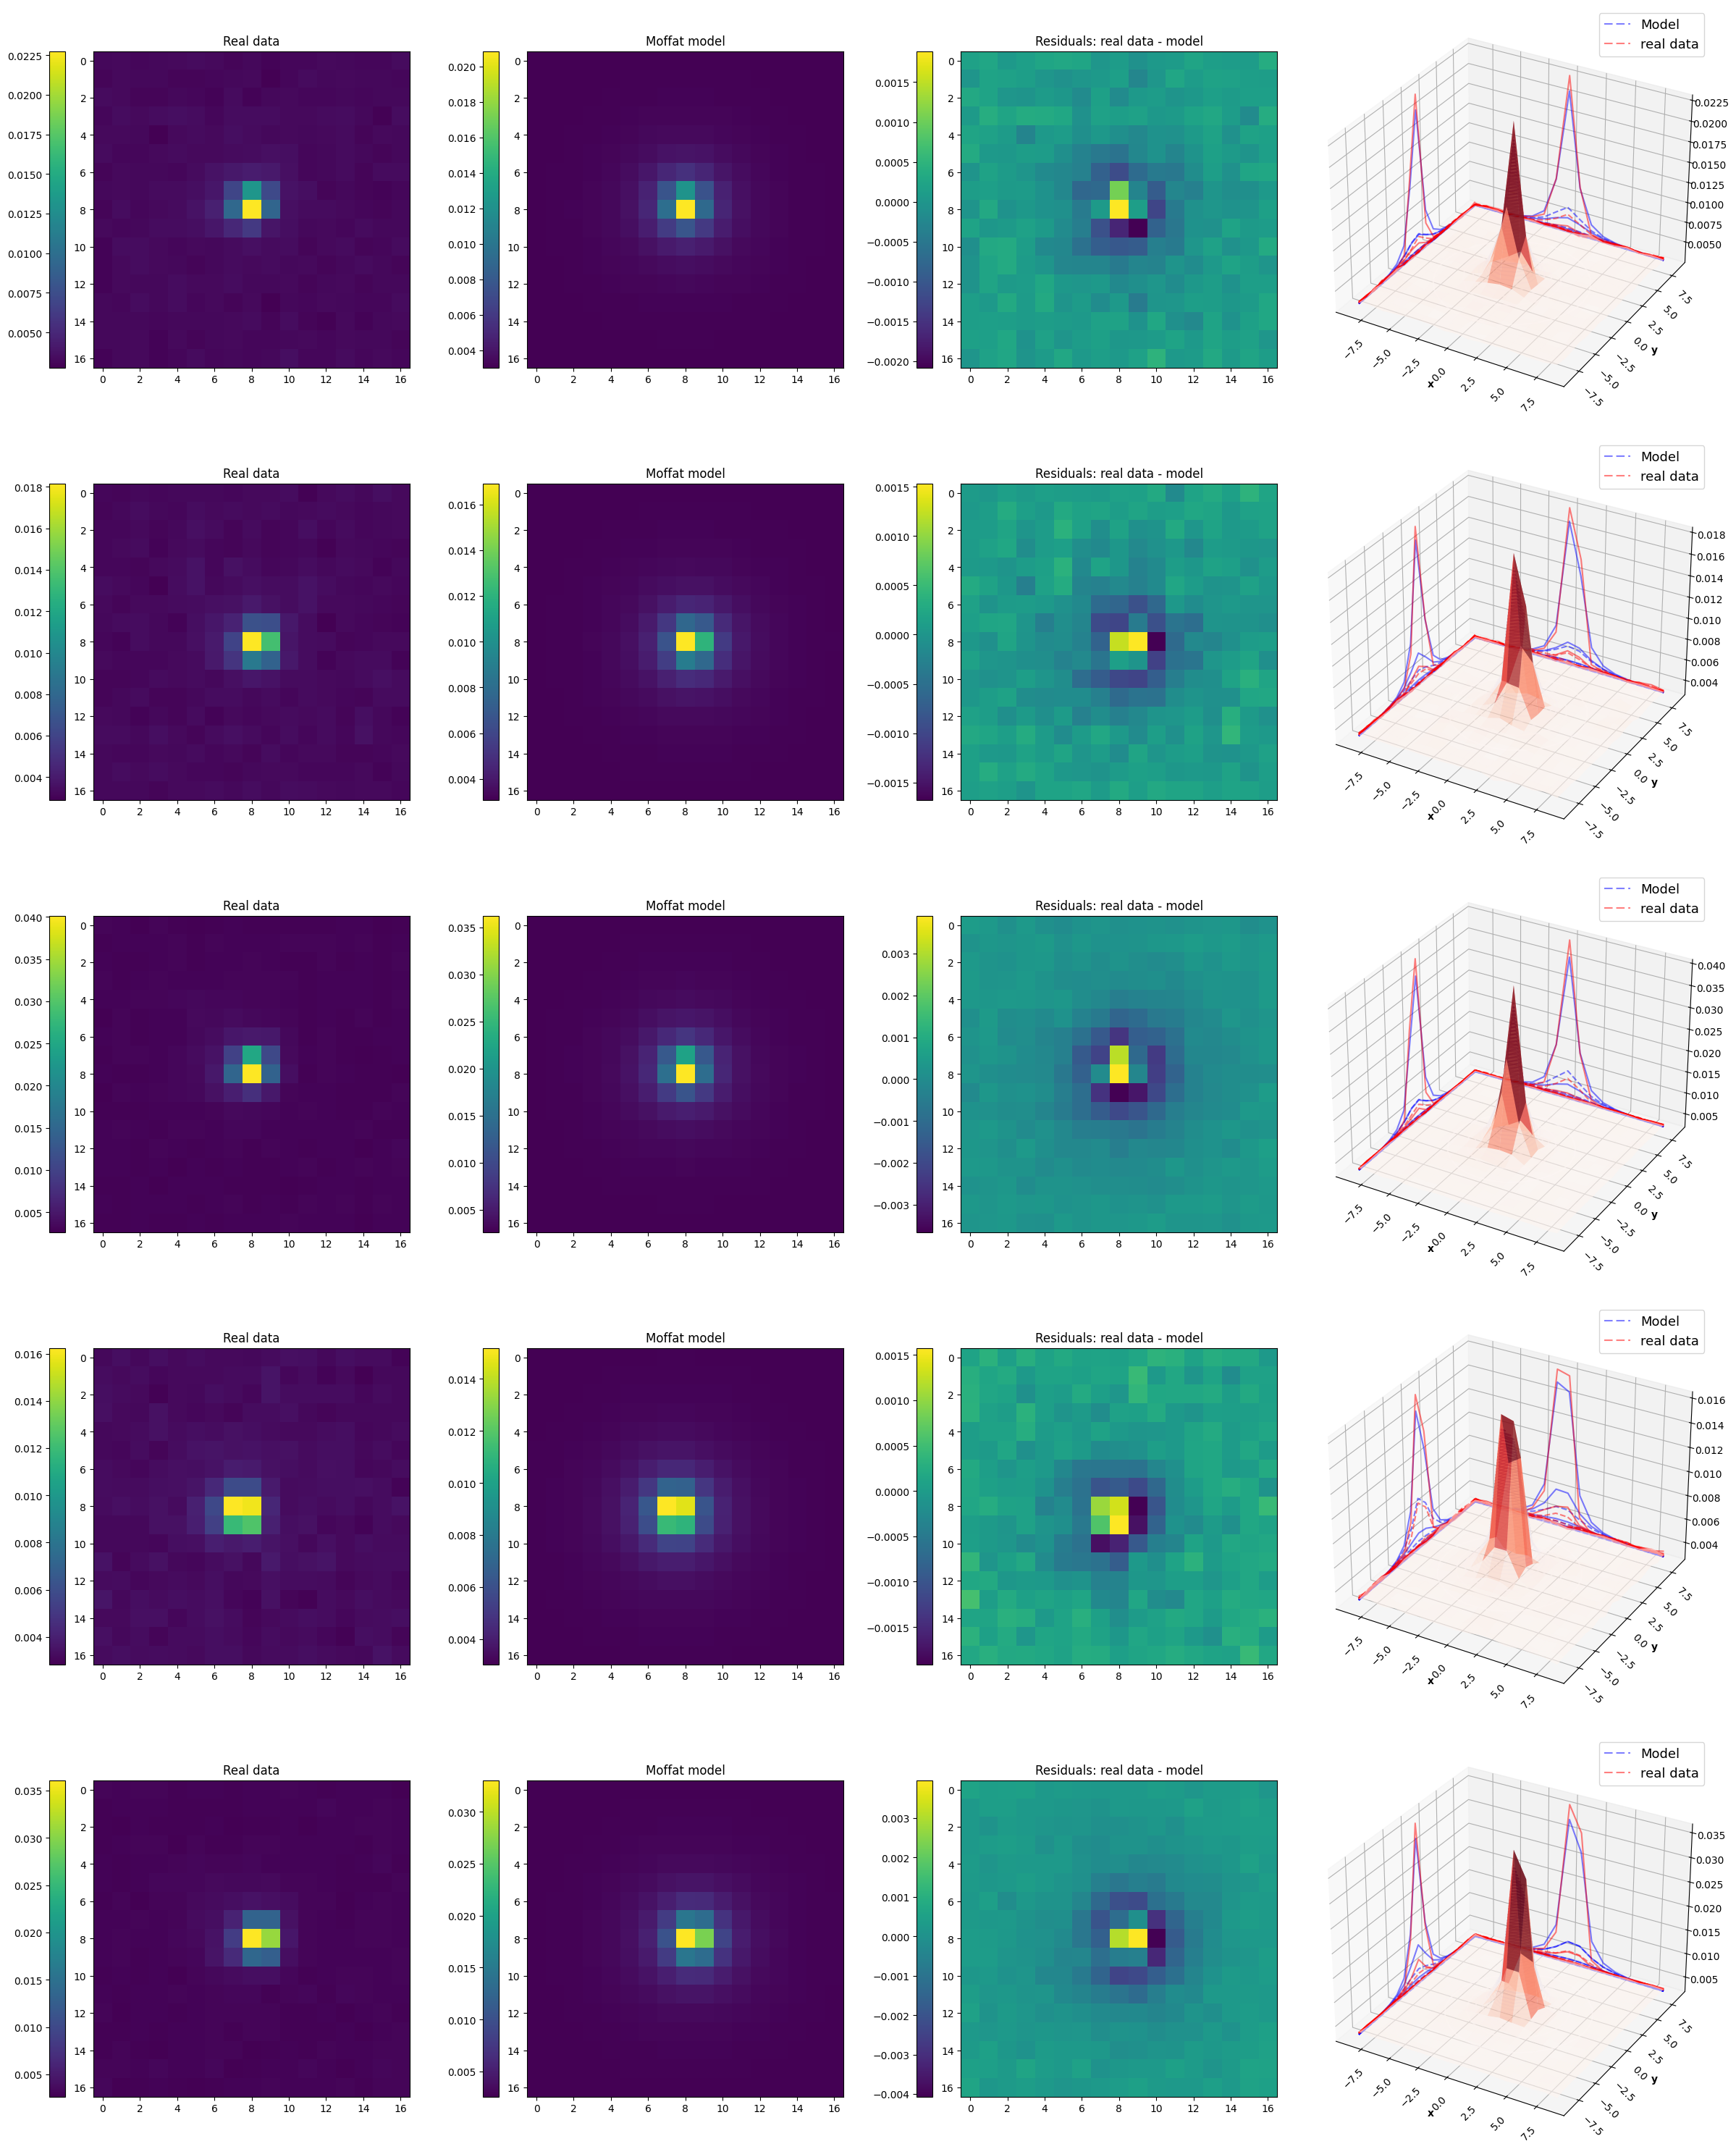

In [10]:
models_moffat = get_model(tncg_params)
total_images = 5
end = qimg_catalog_isolated_mag_bord.head(total_images)
plots(models_moffat, stamps)

# Pixel grille pour une étoile

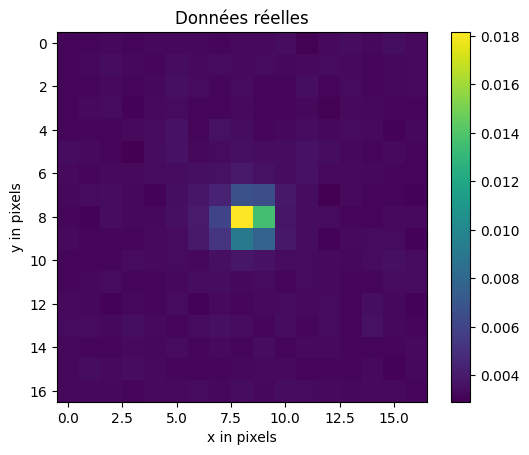

In [11]:
df = qimg_catalog_isolated_mag_bord.loc[3314]
x = df.x
y = df.y
x0 = int(round(x))
y0 = int(round(y))
size = 17
left = x0 - (size // 2)
top = y0 - (size // 2)
right = left + size
bottom = top + size
q_data = q1.get_data()
stamp = q_data[top:bottom, left:right]
to_fit = stamp/stamp.sum()

X = jnp.linspace(left, right, size) - x0
Y = jnp.linspace(top, bottom, size) - y0
X, Y = jnp.meshgrid(X, Y)

plt.imshow(to_fit)
plt.title('Données réelles')
plt.xlabel("x in pixels")
plt.ylabel("y in pixels")
plt.colorbar()
plt.show()

In [12]:
size = 17 #taille de l'image to_fit
pixel_size_to_fit = 1 #taille du pixel de to_fit

grid_size = 19 #taille de l'image grid
pixel_size_grid = 1.5 #taille du pixel de grid

In [13]:
# Coordonnées des coins des pixels dans l'image to_fit
x_to_fit = jnp.linspace(left, right, size)
y_to_fit = jnp.linspace(top, bottom, size)
X_to_fit, Y_to_fit = jnp.meshgrid(x_to_fit, y_to_fit)

# Coordonnées des coins des pixels dans la nouvelle grille
x_grid = jnp.linspace(left, right, grid_size)
y_grid = jnp.linspace(top, bottom, grid_size)
X_grid, Y_grid = jnp.meshgrid(x_grid, y_grid)

In [14]:
%%time

# Axes
X_to_fit_start = X_to_fit[:, :, None, None]
Y_to_fit_start = Y_to_fit[:, :, None, None]
X_to_fit_end = X_to_fit + pixel_size_to_fit
X_to_fit_end = X_to_fit_end[:, :, None, None]
Y_to_fit_end = Y_to_fit + pixel_size_to_fit
Y_to_fit_end = Y_to_fit_end[:, :, None, None]

X_grid_start = X_grid[None, None, :, :]
Y_grid_start = Y_grid[None, None, :, :]
X_grid_end = X_grid + pixel_size_grid
X_grid_end = X_grid_end[None, None, :, :]
Y_grid_end = Y_grid + pixel_size_grid
Y_grid_end = Y_grid_end[None, None, :, :]

# Calcul des chevauchements
X_overlap = jnp.maximum(0, jnp.minimum(X_to_fit_end, X_grid_end) - jnp.maximum(X_to_fit_start, X_grid_start))
Y_overlap = jnp.maximum(0, jnp.minimum(Y_to_fit_end, Y_grid_end) - jnp.maximum(Y_to_fit_start, Y_grid_start))

# Calcul de l'aire de chevauchement
overlap_area = X_overlap * Y_overlap

# Normalisation
proportion_overlap = overlap_area / pixel_size_to_fit

# Grille et calcul du pourcentage de chevauchement
grid = jnp.sum(proportion_overlap * to_fit[:, :, None, None], axis=(0, 1))
percentages = (grid / grid.sum()) * 100
#print(percentages)

CPU times: user 579 ms, sys: 336 ms, total: 915 ms
Wall time: 2 s


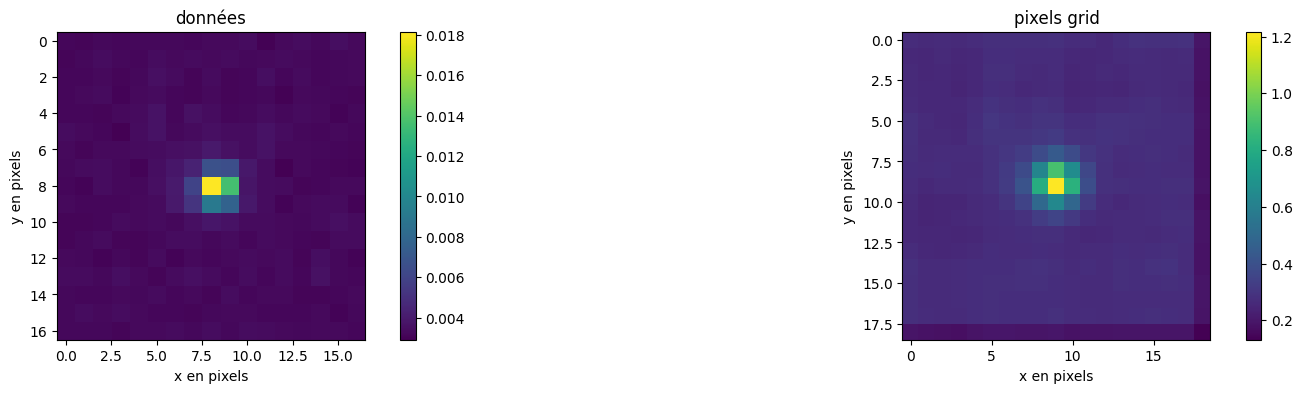

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,4))

im1 = ax1.imshow(to_fit)
plt.colorbar(im1, ax=ax1)
ax1.set_title('données')
ax1.set_xlabel('x en pixels')
ax1.set_ylabel('y en pixels')

im2 = ax2.imshow(percentages)
plt.colorbar(im2, ax=ax2)
ax2.set_title('pixels grid' )
ax2.set_xlabel('x en pixels')
ax2.set_ylabel('y en pixels')
plt.show()

# Pixel grille pour toutes les étoiles du dataframe

In [16]:
def get_stamps(dataframe, size=17):
    """
    Parameters:
    ----------
    dataframe: pandas.dataframe
        dataframe of stars's data from Gaia dr2
    size: int
        stamp size (17,17)

    Returns:
    --------
    stamps: np.asarray
        data of the star image
    """
    stamps = []
    for index, df in qimg_catalog_isolated_mag_bord.iterrows():
        x0 = int(round(df["x"]))
        y0 = int(round(df["y"]))
        left = x0 - (size // 2)
        top = y0 - (size // 2)
        right = left + size
        bottom = top + size
        stamps.append(qimg1[top:bottom, left:right])
    return np.asarray(stamps)

In [17]:
stamps = get_stamps(qimg_catalog_isolated_mag_bord)
coefs = np.sum(stamps, axis=(1,2))
stamps/=coefs[:,None, None]
coords = jnp.array(qimg_catalog_isolated_mag_bord[['x', 'y']])

In [18]:
def calculate_grid_overlap(coords, stamps, size, grid_size, pixel_size_to_fit, pixel_size_grid):
    half_size = size // 2
    left = coords[:, 0] - half_size
    top = coords[:, 1] - half_size
    right = left + size
    bottom = top + size
    
    x_to_fit = jnp.linspace(-half_size, half_size, size)
    y_to_fit = jnp.linspace(-half_size, half_size, size)
    X_to_fit, Y_to_fit = jnp.meshgrid(x_to_fit, y_to_fit)
    
    x_grid = jnp.linspace(-half_size, half_size, grid_size)
    y_grid = jnp.linspace(-half_size, half_size, grid_size)
    X_grid, Y_grid = jnp.meshgrid(x_grid, y_grid)
    pos = jnp.vstack((X_grid.ravel(), Y_grid.ravel())).T
    
    X_to_fit_start = X_to_fit[:, :, None, None]
    Y_to_fit_start = Y_to_fit[:, :, None, None]
    X_to_fit_end = X_to_fit_start + pixel_size_to_fit
    Y_to_fit_end = Y_to_fit_start + pixel_size_to_fit
    
    X_grid_start = X_grid[None, None, :, :]
    Y_grid_start = Y_grid[None, None, :, :]
    X_grid_end = X_grid_start + pixel_size_grid
    Y_grid_end = Y_grid_start + pixel_size_grid
    
    X_overlap = jnp.maximum(0, jnp.minimum(X_to_fit_end, X_grid_end) - jnp.maximum(X_to_fit_start, X_grid_start))
    Y_overlap = jnp.maximum(0, jnp.minimum(Y_to_fit_end, Y_grid_end) - jnp.maximum(Y_to_fit_start, Y_grid_start))
    
    overlap_area = X_overlap * Y_overlap
    proportion_overlap = overlap_area / pixel_size_to_fit
    
    grids = jnp.array([
        jnp.sum(proportion_overlap * stamps[i, :, :, None, None], axis=(0, 1))
        for i in range(stamps.shape[0])
    ])
    
    percentages = grids / grids.sum(axis=(1, 2), keepdims=True)
    return percentages, pos

In [19]:
%%time

size = 17 #taille de l'image to_fit
pixel_size_to_fit = 1 #taille du pixel de to_fit
grid_size = 19 #taille de l'image grid
pixel_size_grid = 1.8 #taille du pixel de grid

percentages, pos = calculate_grid_overlap(coords, stamps, size, grid_size, pixel_size_to_fit, pixel_size_grid)

CPU times: user 842 ms, sys: 428 ms, total: 1.27 s
Wall time: 2.07 s


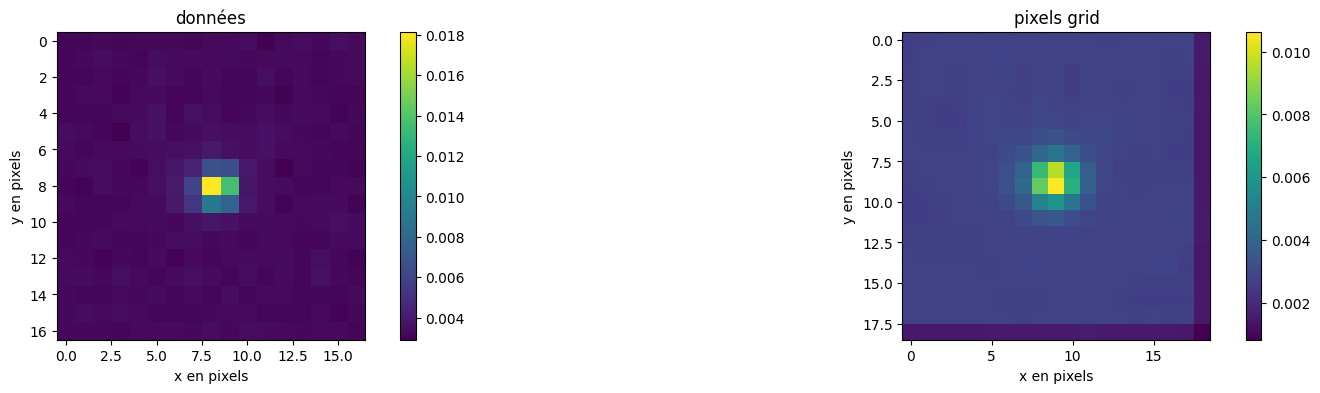

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,4))

im1 = ax1.imshow(stamps[1])
plt.colorbar(im1, ax=ax1)
ax1.set_title('données')
ax1.set_xlabel('x en pixels')
ax1.set_ylabel('y en pixels')

im2 = ax2.imshow(percentages[1])
plt.colorbar(im2, ax=ax2)
ax2.set_title('pixels grid' )
ax2.set_xlabel('x en pixels')
ax2.set_ylabel('y en pixels')

plt.show()

## fit Gaussienne symetric

In [21]:
@jax.jit
def get_model_gauss(params):
    """
    returns the normalized Gaussian function
    =>
    Parameters:
    -----------
    params: pytree
        [mu: (2,N) centroids
         a: (N,) amplitudes
         b: (N,) backgrounbds
         sigmax: (1,) float
         sigmay: (1,) float
         ]
    Returns:
    -------
    model : arraylike
        the normalized Gaussian function
    """
    mu, a, b, sigmax, sigmay = params
    
    cov = jnp.asarray(([sigmax**2 , 0] , [0, sigmay**2]), dtype="float32")
    norm = jstats.multivariate_normal.pdf(pos[None,:],  # same structure for all stars
                                      mean = mu[:,None], # one position per star
                                      cov = cov[None,:] # same cov for all stars
                                     )
    norm_model =  a[:,None]*norm + b[:,None] # (N, size*size)
    return norm_model

@jax.jit
def get_likelihood_gauss(params):
    """
    Computes the Chi squared from selected model 
    
    Parameters:
    ----------
    params: list
        selected model parameters
    stamp: arraylike
        image of one star
    
    Returns:
    --------
    summ: float
        chi squared
    """
    model = get_model_gauss(params)
    summ = jnp.sum((model - data)**2)
    return summ


@jax.jit
def get_logprior_gauss(params):
    """
    Returns the probability to have sigmax and sigma y
    
    Parameters:
    -----------
    params: list
        selected model parameters
    
    Returns:
    -------
    logprior: float
        sum of the two sigma probabilities
    """
    mu, a, b, sigmax, sigmay = params
    logprior_sx = jstats.norm.logpdf(sigmax, loc=1, scale=0.5) # float
    logprior_sy = jstats.norm.logpdf(sigmay, loc=1, scale=0.5) # float
    logprior = logprior_sx + logprior_sy # get the maximize
    return logprior

@jax.jit
def get_logprob_gauss(params):
    """ 
    Computes the sum of the sigma probabilities and the chi squared
    
    Parameters:
    -----------
    params: list
        selected model parameters
    stamp: arraylike
        image of one star
    
    Returns:
    logprob: float
        sum of the sigma probabilities and the chi squared
    """
    logprior = -1* get_logprior_gauss(params) # to minimize
    likelihood = get_likelihood_gauss(params)
    logprob = logprior + likelihood
    return logprob

In [22]:
nstars = len(percentages)

# guess
x0 = jnp.zeros((nstars,), dtype="float32")
y0 = jnp.zeros((nstars,), dtype="float32")
mu = jnp.vstack([x0,y0]).T
sigmax, sigmay = 1., 1.
cov = jnp.asarray(([sigmax**2 , 0] , [0, sigmay**2]), dtype="float32")
a = jnp.ones((nstars,), dtype="float32")
b = jnp.zeros((nstars,), dtype="float32")

data = percentages.reshape(len(percentages), -1)
grad_func = jax.jit(jax.grad(get_logprob_gauss)) # get the derivative

In [23]:
%%time
guess_gauss = [mu, a, b, sigmax, sigmay]
tncg_params_gauss, tncg_loss_gauss = fit_tncg(get_logprob_gauss, guess_gauss, tol=1e-5, niter=50, lmbda=10000)

CPU times: user 6.81 s, sys: 859 ms, total: 7.66 s
Wall time: 6.11 s


In [24]:
def plots_pg(models, percentages):

    num_cols = 4
    num_rows = len(end)
    fig_height = num_rows * 6
    fig_width = num_cols * 6

    fig, axes = plt.subplots(num_rows, num_cols, figsize = (fig_width, fig_height))

    for i, (index, row) in enumerate(end.iterrows()):
        ax1 = axes[i,0]
        im1 = ax1.imshow(percentages[i].reshape(grid_size,grid_size))
        ax1.set_title('Real data + pixel grid')
        plt.colorbar(im1, ax=ax1, location = 'left', orientation = 'vertical', shrink=0.75, pad=0.07)
        ax2 = axes[i,1]
        im2 = ax2.imshow(models[i].reshape(grid_size,grid_size))
        ax2.set_title('model')
        plt.colorbar(im2, ax=ax2, location = 'left', orientation = 'vertical', shrink=0.75, pad=0.07)
        ax3 = axes[i,2]
        im3 = ax3.imshow(percentages[i].reshape(grid_size,grid_size)- models[i].reshape(grid_size,grid_size))
        ax3.set_title('Residuals: (real data + pixel grid) - model')
        plt.colorbar(im3, ax=ax3, location = 'left', orientation = 'vertical', shrink=0.75, pad=0.07)
        ax4 = axes[i, 3]
        fig = plt.gcf()
        spec = ax4.get_subplotspec()
        fig.delaxes(ax4)
        ax4_3d = fig.add_subplot(spec, projection='3d')
        ax4_3d.plot_surface(X_grid, Y_grid, percentages[i].reshape(grid_size,grid_size), cmap='Reds', alpha=0.6, label='real data')
        ax4_3d.contour3D(X_grid, Y_grid, models[i].reshape(grid_size,grid_size), levels=50, cmap='Purples', alpha=0.6)
        ax4_3d.set_xlabel('x', fontdict=dict(weight='bold'))
        ax4_3d.set_ylabel('y', fontdict=dict(weight='bold'))
        ax4_3d.xaxis.set_tick_params(rotation=45)
        ax4_3d.yaxis.set_tick_params(rotation=-45)
        c1 = ax4_3d.contour(X_grid, Y_grid, models[i].reshape(grid_size, grid_size), 8, zdir='y', offset=np.max(Y_grid), colors='blue', alpha=0.5)
        c2 = ax4_3d.contour(X_grid, Y_grid, percentages[i].reshape(grid_size, grid_size), 8, zdir='y', offset=np.max(Y_grid), colors='red', alpha=0.5)
        ax4_3d.contour(X_grid, Y_grid, models[i].reshape(grid_size, grid_size), 8, zdir='x', offset=np.min(X_grid), colors='blue', alpha=0.5)
        ax4_3d.contour(X_grid, Y_grid, percentages[i].reshape(grid_size, grid_size), 8, zdir='x', offset=np.min(X_grid), colors='red', alpha=0.5)
        h1, _ = c1.legend_elements()
        h2, _ = c2.legend_elements()
        ax4_3d.legend([h1[0], h2[0]], ['Model', 'real data + pixel grid'], fontsize=13)
    
    plt.tight_layout()
    plt.show()

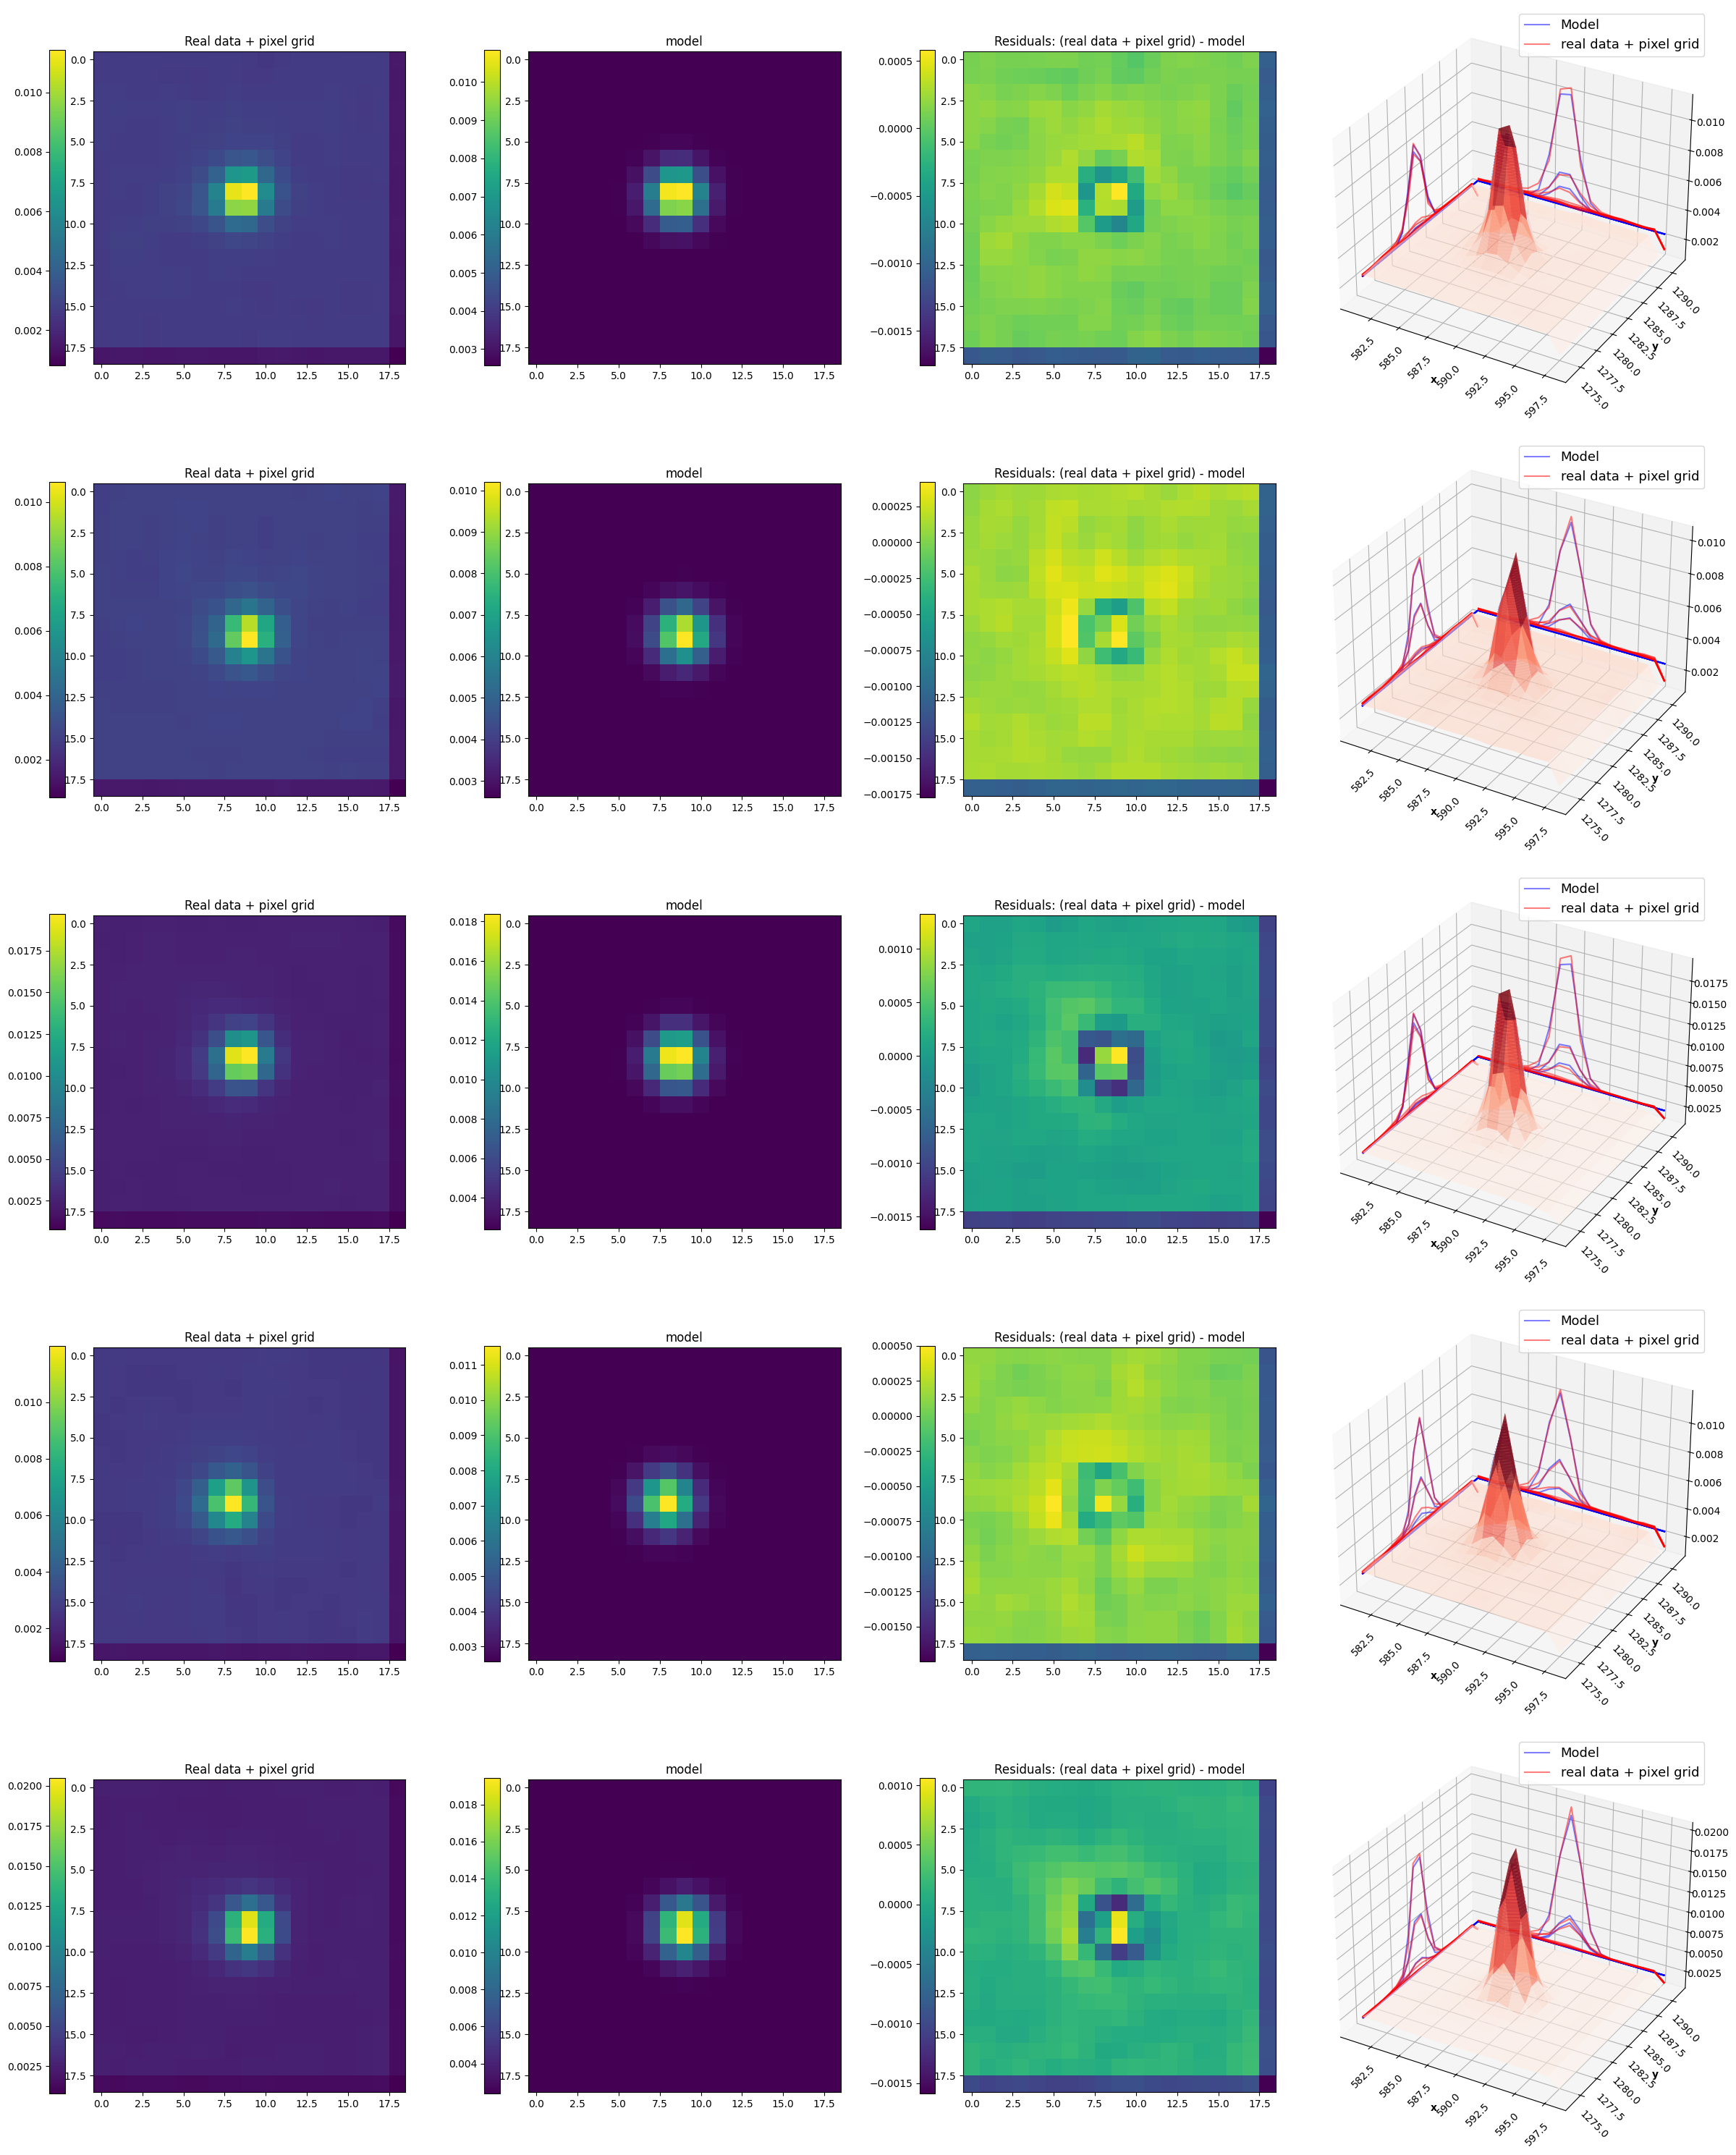

In [25]:
models_gauss = get_model_gauss(tncg_params_gauss)
total_images = 5
end = qimg_catalog_isolated_mag_bord.head(total_images)
plots_pg(models_gauss, percentages)

## fit Gaussienne elliptic

In [26]:
def gauss_elliptic(x, y, x0, y0, A, sigmax, sigmay):
    x_sqrd = (x - x0)**2
    y_sqrd = (y - y0)**2
    exponent = -(x_sqrd / (2*sigmax**2)) - (y_sqrd / (2*sigmay**2))
    return A * jnp.exp(exponent)

def get_model_gauss_elliptic(params):

    mu, A, b, sigmax, sigmay = params
    x0, y0 = mu[:, 0], mu[:, 1]

    vectorized_gauss = vmap(gauss_elliptic, in_axes=(None, None, 0, 0, 0, None, None))
    norm = vectorized_gauss(pos[:, 0], pos[:, 1], x0, y0, A, sigmax, sigmay)
    norm_model = norm + b[:, None]
    
    return norm_model

@jax.jit
def get_likelihood_gauss_elliptic(params):
    """
    Computes the Chi squared from selected model 
    
    Parameters:
    ----------
    params: list
        selected model parameters
    stamp: arraylike
        image of one star
    
    Returns:
    --------
    summ: float
        chi squared
    """
    model = get_model_gauss_elliptic(params)
    summ = jnp.sum((model - data)**2)
    return summ


@jax.jit
def get_logprior_gauss_elliptic(params):
    """
    Returns the probability to have sigmax and sigma y
    
    Parameters:
    -----------
    params: list
        selected model parameters
    
    Returns:
    -------
    logprior: float
        sum of the two sigma probabilities
    """
    mu, A, b, sigmax, sigmay = params
    logprior_sx = jstats.norm.logpdf(sigmax, loc=1, scale=0.5) # float
    logprior_sy = jstats.norm.logpdf(sigmay, loc=1, scale=0.5) # float
    logprior = logprior_sx + logprior_sy # get the maximize
    return logprior

@jax.jit
def get_logprob_gauss_elliptic(params):
    """ 
    Computes the sum of the sigma probabilities and the chi squared
    
    Parameters:
    -----------
    params: list
        selected model parameters
    stamp: arraylike
        image of one star
    
    Returns:
    logprob: float
        sum of the sigma probabilities and the chi squared
    """
    logprior = -1* get_logprior_gauss_elliptic(params) # to minimize
    likelihood = get_likelihood_gauss_elliptic(params)
    logprob = logprior + likelihood
    return logprob

In [27]:
nstars = len(percentages)

# guess
x0 = jnp.zeros((nstars,), dtype="float32")
y0 = jnp.zeros((nstars,), dtype="float32")
mu = jnp.vstack([x0,y0]).T
A = jnp.ones((nstars,), dtype="float32")  
b = jnp.zeros((nstars,), dtype="float32")
sigmax = jnp.array(1., dtype="float32")  
sigmay = jnp.array(1., dtype="float32") 

data = percentages.reshape(len(percentages), -1)
grad_func = jax.jit(jax.grad(get_logprob_gauss_elliptic))

In [28]:
%%time
guess_gauss_elliptic = [mu, A, b, sigmax, sigmay]
tncg_params_gauss_elliptic, tncg_loss_gauss_elliptic = fit_tncg(get_logprob_gauss_elliptic, guess_gauss_elliptic, tol=1e-5, niter=100, lmbda=5000)

CPU times: user 4.56 s, sys: 421 ms, total: 4.98 s
Wall time: 3.86 s


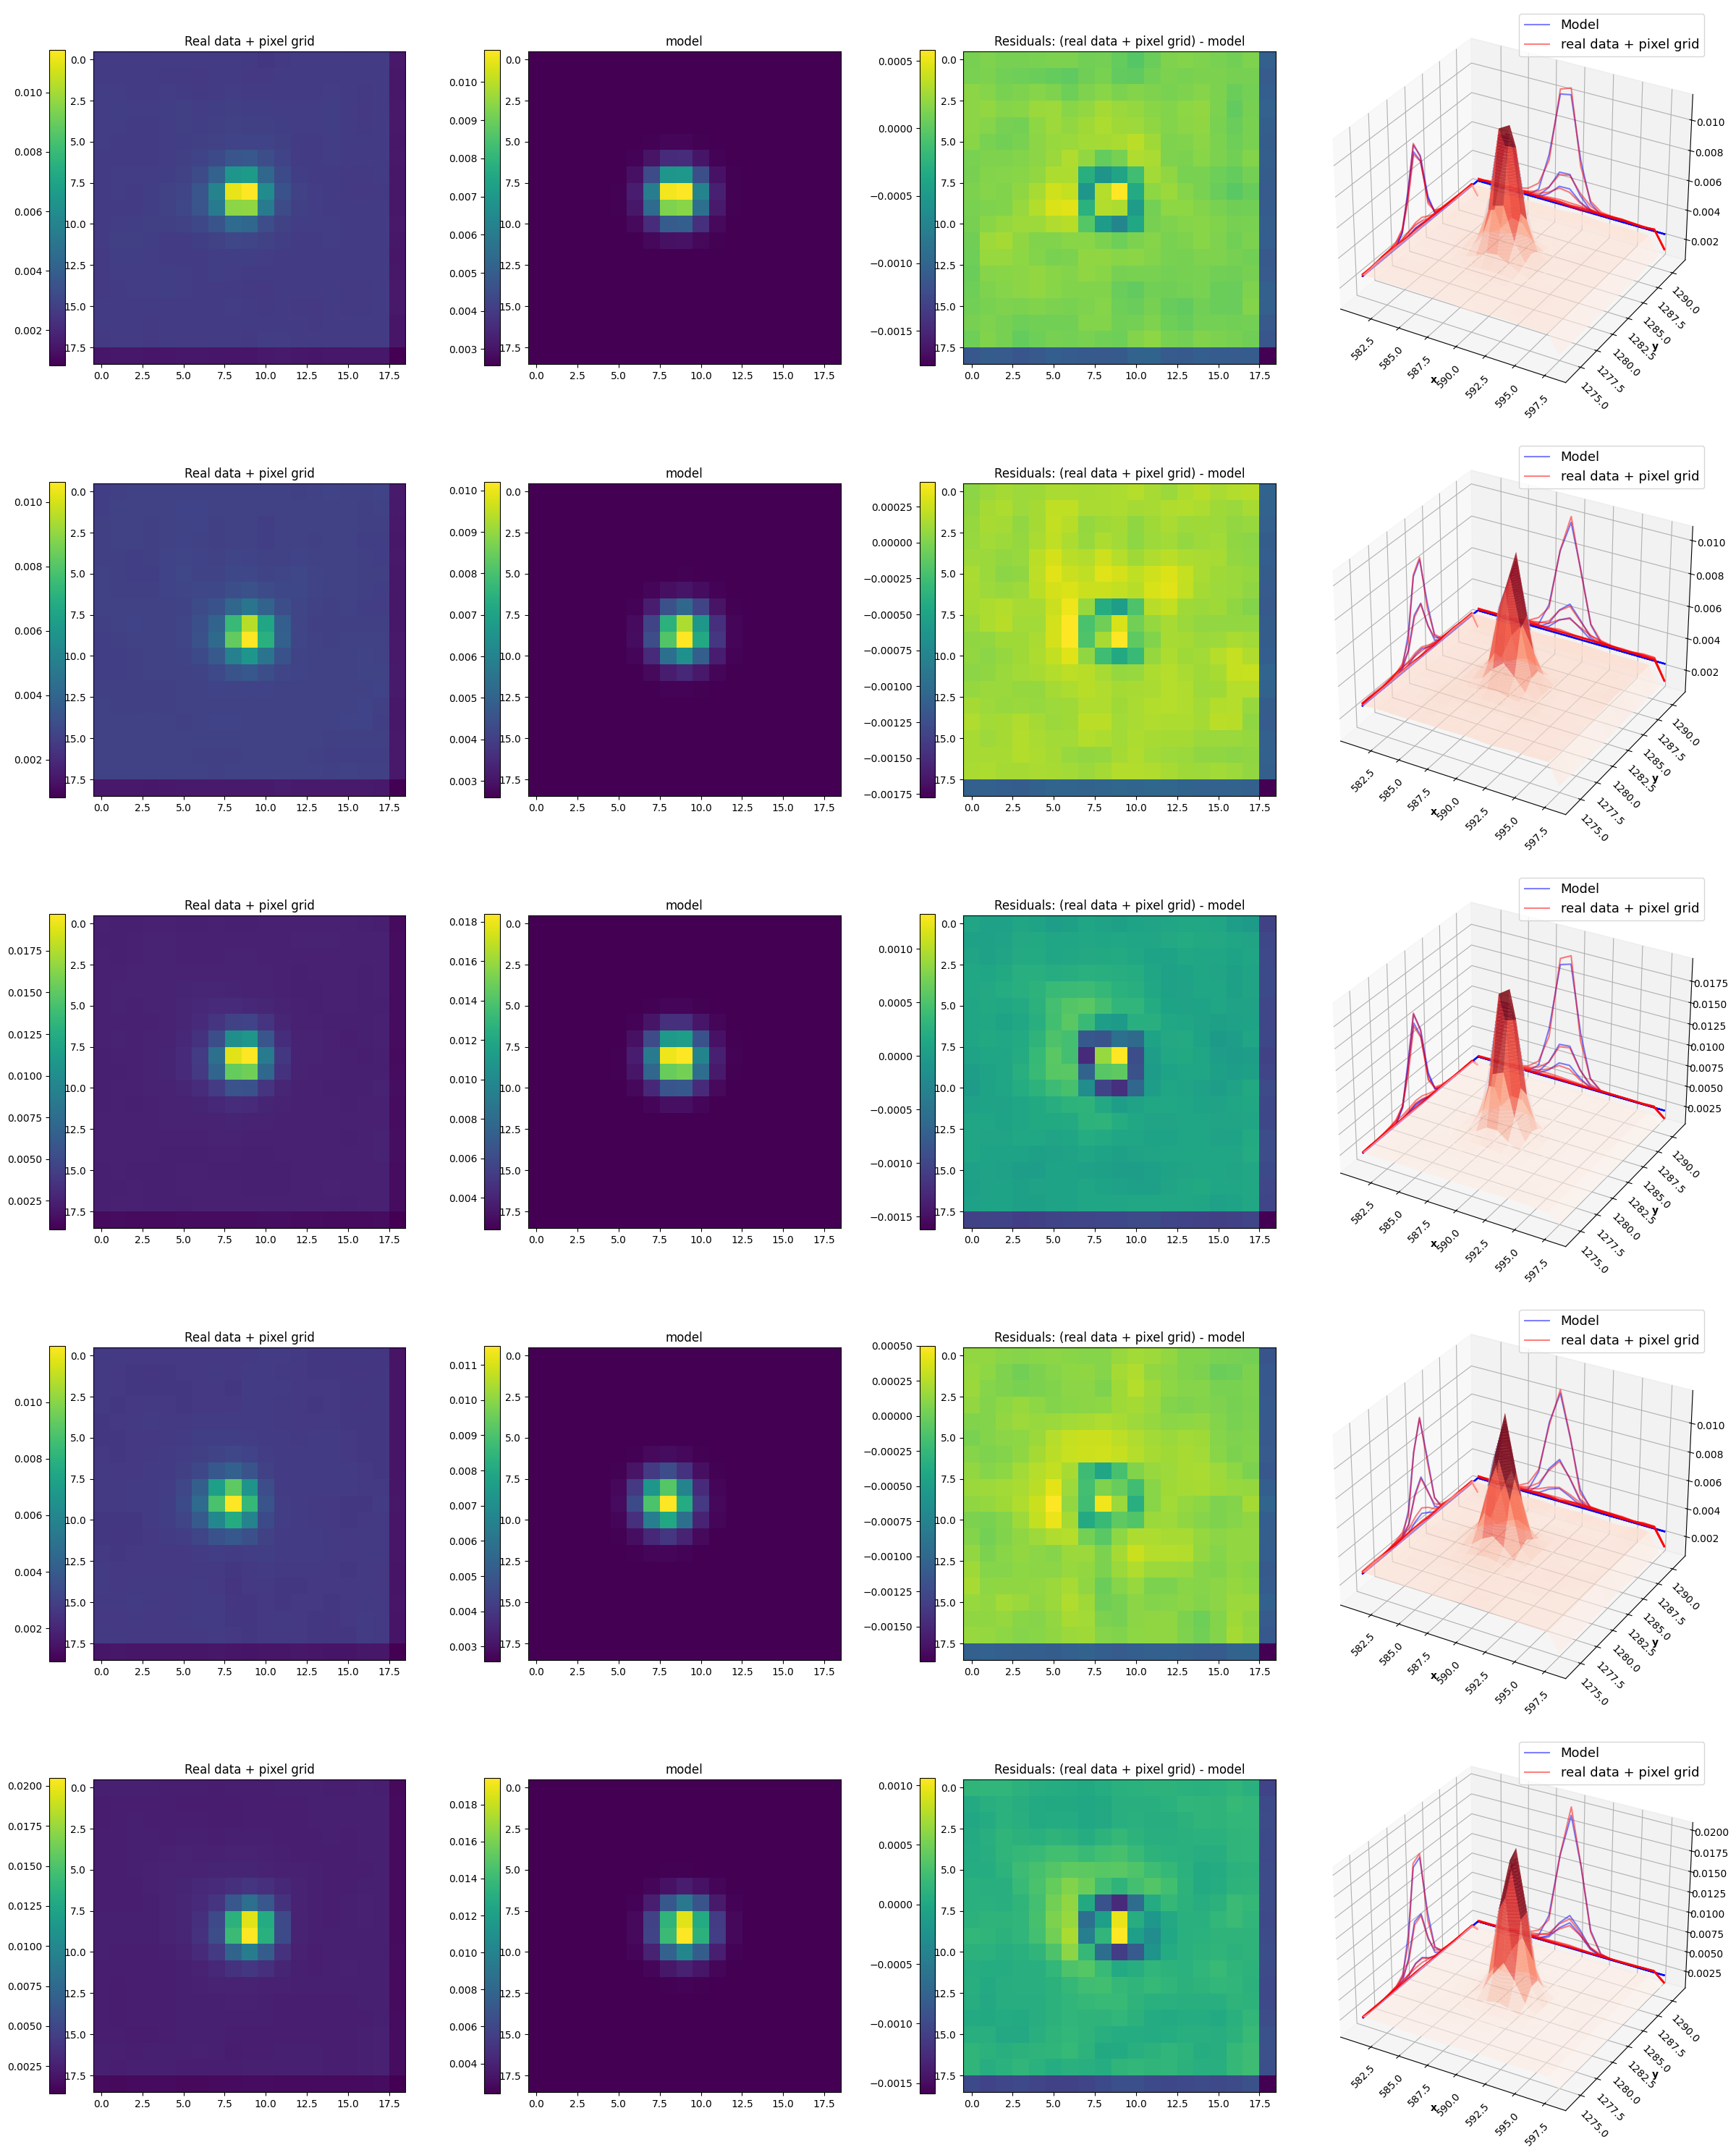

In [29]:
models_gauss_elliptic = get_model_gauss_elliptic(tncg_params_gauss_elliptic)
total_images = 5
end = qimg_catalog_isolated_mag_bord.head(total_images)
plots_pg(models_gauss_elliptic, percentages)

## fit Moffat

In [30]:
def moffat(x, y, x0, y0, A, alpha, gamma):
    r_squared = (x - x0)**2 + (y - y0)**2
    return A * (1 + (r_squared / gamma**2))**(-alpha)


@jax.jit
def get_model_moffat(params):
    """
    Returns the Moffat function

    Parameters:
    -----------
    params: pytree
        [x0,y0: (2,N) centroids
         a: (N,) amplitudes
         b: (N,) backgrounds
         gamma: (1,) float
         alpha: (1,) float]
    
    Returns:
    -------
    model : arraylike
        the Moffat function
    """
    mu, A, b, alpha, gamma = params
    x0, y0 = mu[:, 0], mu[:, 1]
    
    vectorized_moffat = vmap(moffat, in_axes=(None, None, 0, 0, 0, None, None)) # to vectorize on centroids
    norm = vectorized_moffat(pos[:, 0], pos[:, 1], x0, y0, A, alpha, gamma)
    norm_model = norm + b[:, None]
    
    return norm_model
    
@jax.jit
def get_likelihood_moffat(params):
    """
    Computes the Chi squared from the selected model 

    Parameters:
    ----------
    params: list
        selected model parameters
    data: arraylike
        images of stars (flattened)
    pos: arraylike
        The positions (meshgrid) where the model is evaluated.

    Returns:
    --------
    summ: float
        chi squared sum for all stars
    """
    model = get_model_moffat(params)
    summ = jnp.sum((model - data)**2)
    return summ


@jax.jit
def get_logprior_moffat(params):
    """
    Returns the probability to have gamma and alpha
    
    Parameters:
    -----------
    params: list
        selected model parameters

    X: arraylike
        The X coordinates.

    Y: arraylike
        The Y coordinates.
    
    Returns:
    -------
    logprior: float
        sum of the two sigma probabilities
    """
    mu, A, b, alpha, gamma = params
    logprior_alpha = jstats.norm.logpdf(alpha, loc=1.0, scale=0.5) 
    logprior_gamma = jstats.norm.logpdf(gamma, loc=1.0, scale=0.5) 
    logprior = logprior_alpha + logprior_gamma
    return logprior

@jax.jit
def get_logprob_moffat(params):
    """ 
    Computes the sum of the gamma and alpha probabilities and the chi squared

    Parameters:
    -----------
    params: list
        selected model parameters
    data: arraylike
        images of stars (flattened)
    pos: arraylike
        The positions (meshgrid) where the model is evaluated.

    Returns:
    --------
    logprob: float
        sum of the sigma probabilities and the chi squared
    """
    logprior = -1 * get_logprior_moffat(params)  # to minimize
    likelihood = get_likelihood_moffat(params)
    logprob = logprior + likelihood
    return logprob

In [31]:
# guess
x0 = jnp.zeros((nstars,), dtype="float32")
y0 = jnp.zeros((nstars,), dtype="float32")
mu = jnp.vstack([x0,y0]).T
A = jnp.ones((nstars,), dtype="float32")  
b = jnp.zeros((nstars,), dtype="float32")
alpha = jnp.array(1., dtype="float32")  
gamma = jnp.array(1., dtype="float32") 

data = percentages.reshape(len(percentages), -1)
grad_func = jax.jit(jax.grad(get_logprob_moffat))

In [32]:
%%time

guess_moffat = [mu, A, b, alpha, gamma]
tncg_params_moffat_pg, tncg_loss_moffat_pg = fit_tncg(get_logprob_moffat, guess_moffat, tol=1e-5, niter=100, lmbda=5000)

CPU times: user 6.07 s, sys: 488 ms, total: 6.55 s
Wall time: 4.59 s


In [ ]:
models_moffat_pg = get_model_moffat(tncg_params_moffat_pg)
total_images = 15
end = qimg_catalog_isolated_mag_bord.head(total_images)
plots_pg(models_moffat_pg, percentages)

# Calcul des résidus avec et sans pixel grille pour la Moffat

In [ ]:
print("taille de stamps", stamps.shape)
print("taille de models_moffat", models_moffat.shape)
print("taille de percentages", percentages.shape)
print("taille de models_moffat_pg", models_moffat_pg.shape)

In [ ]:
total_images = 15
end = qimg_catalog_isolated_mag_bord.head(total_images)

def resize_image(image, new_shape):
    factors = (
        new_shape[0] / image.shape[0],
        new_shape[1] / image.shape[1]
    )
    return zoom(image, factors, order=1)
        
fig, axs = plt.subplots(total_images, 3, figsize=(15, 5 * total_images))

sum_diff = np.zeros((17, 17))

for i, (index, row) in enumerate(end.iterrows()):
    res = stamps[i] - models_moffat.reshape(473,17,17)[i]
    res_pg = percentages[i] - models_moffat_pg.reshape(473,19,19)[i]

    res_pg_resized = resize_image(res_pg, (17,17))

    diff = res - res_pg_resized

    sum_diff += diff

    im0 = axs[i, 0].imshow(res)
    axs[i, 0].set_title('residuals')
    fig.colorbar(im0, ax=axs[i, 0], orientation='vertical', shrink=0.65, pad=0.07)

    im1 = axs[i, 1].imshow(res_pg_resized)
    axs[i, 1].set_title('residuals with pixel_grid')
    fig.colorbar(im1, ax=axs[i, 1], orientation='vertical', shrink=0.65, pad=0.07)

    im2 = axs[i, 2].imshow(diff)
    axs[i, 2].set_title('residuals - residuals with pixel_grid')
    fig.colorbar(im2, ax=axs[i, 2], orientation='vertical', shrink=0.65, pad=0.07)


# plt.figure(figsize=(10, 5))
# plt.imshow(sum_diff)
# plt.colorbar()
# plt.title('Somme des différences')

plt.tight_layout()
plt.show()